<a href="https://colab.research.google.com/github/LiliyaIvanova/ML-Classification/blob/main/Titanic_dataset_training_ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import numpy as np
import seaborn as sns
import pandas as pd
from pandas import Series, DataFrame

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import seaborn as sb
sb.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams   # для конфигурации отображения графиков 
rcParams['figure.figsize'] = 8, 6

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score


In [123]:
import os 
from google.colab import drive

In [124]:
gdrive_dir = '/content/drive/'
drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/drive/


In [130]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/Titanic Dataset '):
  for filename in filenames: 
    print(os.path.join(dirname, filename))

/content/drive/MyDrive/Colab Notebooks/Titanic Dataset /test.csv
/content/drive/MyDrive/Colab Notebooks/Titanic Dataset /train.csv


In [131]:
# Import train dataset
titanic_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic Dataset /train.csv')
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [132]:
# Import test dataset
titanic_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic Dataset /test.csv')
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Предварительная обработка данных

Обработаем тренировочный и тестовый датасеты. 

In [133]:
# count missing values 
titanic_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [134]:
titanic_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

На тренировочном датасете имеем 177 пропущенных значений по Возрасту, 687 записей по Каюте и 2 по городу отправления Титаника. На тестовом - 86 записей по Возрасту, 327 - по Каюте, 1 - стоимость поездки. 

Заполним отсутствующие значения признака 'Age' - средним значением по данному признаку.

In [135]:
titanic_train['Age'].fillna(titanic_train['Age'].mean(), inplace=True)
titanic_test['Age'].fillna(titanic_test['Age'].mean(), inplace=True)

<Figure size 576x432 with 0 Axes>

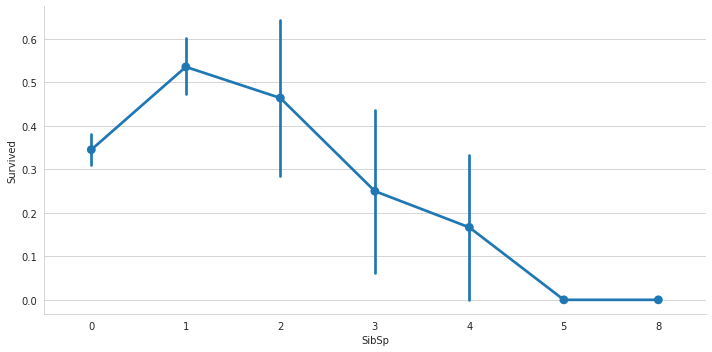

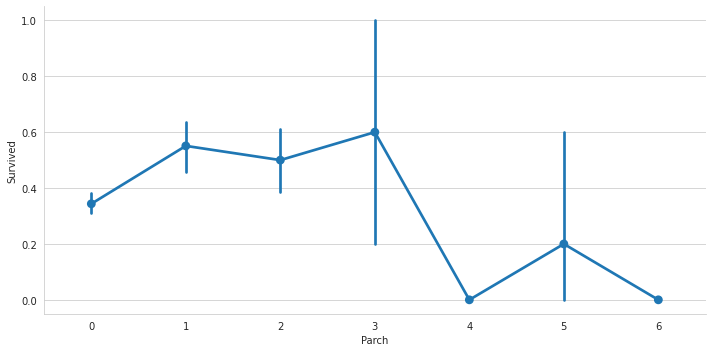

In [136]:
# посмотрим на признаки 'SibSp' и 'Parch'
for i, col in enumerate(['SibSp', 'Parch']):
  plt.figure(i)
  sns.catplot(x=col, y='Survived', data=titanic_train, kind='point', aspect=2)

1 график - взаимосвязь между выживанием и количеством братьев и сестер на борту. Те, у кого было больше братьев и сестер - выжили в меньшем количестве.

2 график - взаимосвязь между выживанием и размером семьи (родители и дети на борту). Возможно, люди, которые приобрели билеты по низкой цене имели большие семьи. 


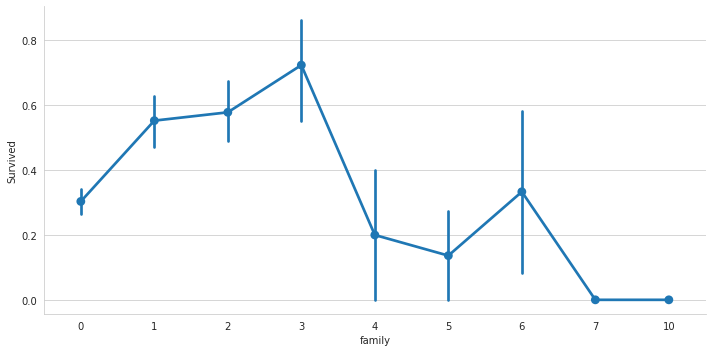

In [137]:
# объединим признаки 'SibSp' и 'Parch' в один - 'family' и удалим их 
titanic_train['family'] = titanic_train['SibSp'] + titanic_train['Parch']
sns.catplot(x='family', y='Survived', data=titanic_train, kind='point', aspect=2)

In [138]:
titanic_train.drop(['PassengerId', 'SibSp', 'Parch'], axis=1, inplace=True)

In [139]:
titanic_test['family'] = titanic_test['SibSp'] + titanic_test['Parch']
titanic_test.drop(['PassengerId', 'SibSp', 'Parch'], axis=1, inplace=True)

In [140]:
#titanic_train.head()

In [141]:
#titanic_test.head()

In [142]:
# создадим некий бинарный классификатор (отсутствует запись --> 0)
titanic_train['Cabin_index'] = np.where(titanic_train['Cabin'].isnull(), 0, 1) 

titanic_test['Cabin_index'] = np.where(titanic_test['Cabin'].isnull(), 0, 1)

In [143]:
# аналогично и для признака 'Пол'
sex_numeric = {'male': 0, 'female': 1} 
titanic_train['Sex'] = titanic_train['Sex'].map(sex_numeric) 

titanic_test['Sex'] = titanic_test['Sex'].map(sex_numeric) 

In [144]:
# Ещё немного очистим датасет от ненужных признаков
titanic_train.drop(['Cabin', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)

titanic_test.drop(['Cabin', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)

In [145]:
titanic_test.isnull().sum()

Pclass         0
Sex            0
Age            0
Fare           1
family         0
Cabin_index    0
dtype: int64

In [147]:
med = titanic_test['Fare'].median()
print("Медиана = ", med)
titanic_test['Fare'] = titanic_test['Fare'].fillna(med) 
titanic_test.head()

Медиана =  14.4542


,Pclass,Sex,Age,Fare,family,Cabin_index
0,3,0,34.5,7.8292,0,0
1,3,1,47.0,7.0000,1,0
2,2,0,62.0,9.6875,0,0
3,3,0,27.0,8.6625,0,0
4,3,1,22.0,12.2875,2,0


In [148]:
# Save the Data
titanic_train.to_csv('/content/drive/MyDrive/Colab Notebooks/Titanic Dataset /titanic_clean.csv', index=False) 
titanic_test.to_csv('/content/drive/MyDrive/Colab Notebooks/Titanic Dataset /titanic_clean_test.csv', index=False) 

In [149]:
titanic = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic Dataset /titanic_clean.csv')
titanic.head()

,Survived,Pclass,Sex,Age,Fare,family,Cabin_index
0,0,3,0,22.0,7.2500,1,0
1,1,1,1,38.0,71.2833,1,1
2,1,3,1,26.0,7.9250,0,0
3,1,1,1,35.0,53.1000,1,1
4,0,3,0,35.0,8.0500,0,0


# Переходим к обучению

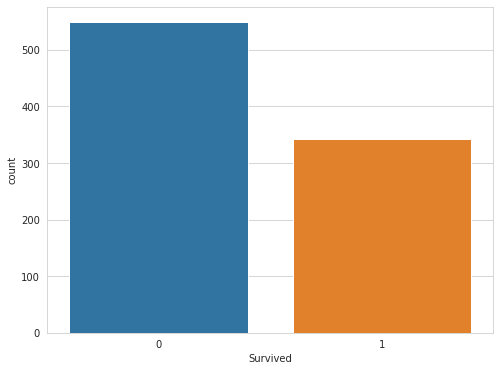

In [150]:
sb.countplot(x='Survived', data=titanic)

In [151]:
features = titanic.drop('Survived', axis=1)
labels = titanic['Survived'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

 # Linear Regression

In [152]:
lin_reg = LinearRegression() 
lin_reg.fit(X_train, y_train) 
acc_lin = lin_reg.score(X_test, y_test)
print(acc_lin)

0.44815891133676056


In [153]:
# intercept - пересечение - значение зависимой перем-й, когда знач незав перем = 0, бета0
# coef - наклон - то, на что умножеаются независимые переменные, бета1, бета2 и тд, изменение функции за одну единицу
print('intercept: ', lin_reg.intercept_)
print('slope: ', lin_reg.coef_)

intercept:  0.5966133653708827
slope:  [-1.08176676e-01  5.03295896e-01 -5.27336368e-03  4.54676714e-04
 -3.27295935e-02  1.22026161e-01]


Как видим, линейная регрессия плохо справляется с задачей классификации. Точность данной модели меньше 0.5. 

## Logistic regression

In [154]:
log_reg = LogisticRegression() 

log_reg.fit(X_train, y_train)
acc_log = log_reg.score(X_test, y_test)
print(acc_log)

0.8283582089552238


Эффективность алгоритма

array([[138,  19],
       [ 27,  84]])

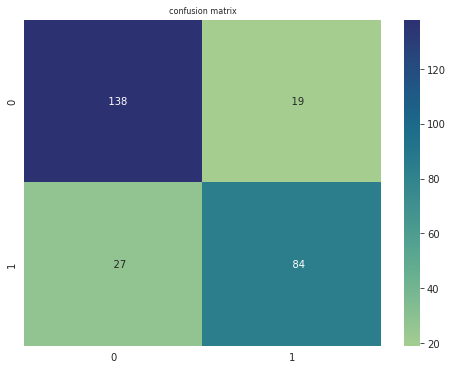

In [155]:
# confusion matrix 
y_pred = log_reg.predict(X_test)
conf_mx = confusion_matrix(y_test, y_pred) 

sb.heatmap(conf_mx, annot=True, fmt='6.0f', cmap='crest')
plt.title('confusion matrix', size=8) 
conf_mx

In [156]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

Accuracy:  0.8283582089552238
Precision:  0.8155339805825242
Recall:  0.7567567567567568


In [157]:
# Посмотрим результат тестового датасета
y_pred_test = log_reg.predict(titanic_test) 
print("OK ", sum(y_pred_test != 0))
print("NOT OK ", sum(y_pred_test == 0))

OK  151
NOT OK  267


Таким образом, на тестовом датасете мы предсказали, что 151 человек выживет, а 266 - нет. 

# k-nearest neighbors (KNN)

In [158]:
knn = KNeighborsClassifier(n_neighbors = 3) 

knn.fit(X_train, y_train)
acc_knn = knn.score(X_test, y_test)
print(acc_knn)  

0.7014925373134329


array([[131,  26],
       [ 54,  57]])

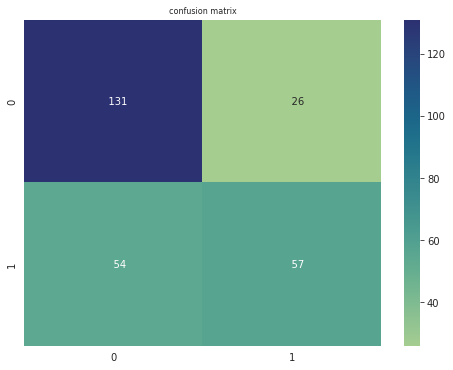

In [159]:
# confusion matrix
y_pred = knn.predict(X_test)  
conf_mx = confusion_matrix(y_test, y_pred) 

sb.heatmap(conf_mx, annot=True, fmt='6.0f', cmap='crest')
plt.title('confusion matrix', size=8) 
conf_mx

In [160]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

Accuracy:  0.7014925373134329
Precision:  0.6867469879518072
Recall:  0.5135135135135135


# Decision Tree 

In [161]:
decision_tree = DecisionTreeClassifier() 

decision_tree.fit(X_train, y_train)  
acc_decision_tree = decision_tree.score(X_test, y_test) 
print(acc_decision_tree)

0.7761194029850746


array([[128,  29],
       [ 31,  80]])

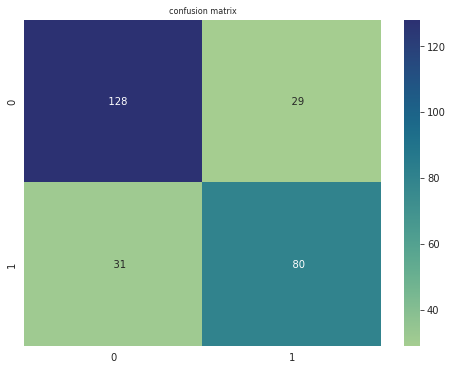

In [162]:
# confusion matrix
y_pred = decision_tree.predict(X_test)  
conf_mx = confusion_matrix(y_test, y_pred) 

sb.heatmap(conf_mx, annot=True, fmt='6.0f', cmap='crest')
plt.title('confusion matrix', size=8) 
conf_mx

In [163]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

Accuracy:  0.7761194029850746
Precision:  0.7339449541284404
Recall:  0.7207207207207207


# Random Forest

In [164]:
random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, y_train)
acc_random_forest = random_forest.score(X_test, y_test)
print(acc_random_forest)

0.7873134328358209


array([[135,  22],
       [ 35,  76]])

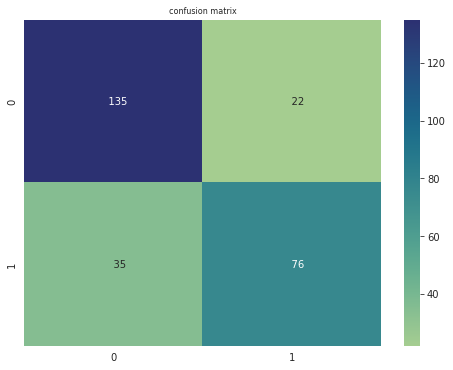

In [165]:
# confusion matrix
y_pred = random_forest.predict(X_test) 
conf_mx = confusion_matrix(y_test, y_pred) 

sb.heatmap(conf_mx, annot=True, fmt='6.0f', cmap='crest')
plt.title('confusion matrix', size=8) 
conf_mx

In [166]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

Accuracy:  0.7873134328358209
Precision:  0.7755102040816326
Recall:  0.6846846846846847


Покажем score для каждой модели в одной таблице. 

In [167]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'],
    'Score': [acc_lin, acc_log, acc_knn, acc_decision_tree, acc_random_forest]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head()

,Model
Score,
0.828358,Logistic Regression
0.787313,Random Forest
0.776119,Decision Tree
0.701493,KNN
0.448159,Linear Regression


## Random Forest & Cross-Validation

In [168]:
titanic.head()

,Survived,Pclass,Sex,Age,Fare,family,Cabin_index
0,0,3,0,22.0,7.2500,1,0
1,1,1,1,38.0,71.2833,1,1
2,1,3,1,26.0,7.9250,0,0
3,1,1,1,35.0,53.1000,1,1
4,0,3,0,35.0,8.0500,0,0


In [169]:
X = titanic.drop('Survived', axis=1)
y = titanic['Survived']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [104]:
#X_test.info()

Cross Validation

In [170]:
rfc = RandomForestClassifier()

scores = cross_val_score(rfc, X_train, y_train, cv=5) 
print(scores)

[0.8        0.8        0.768      0.79032258 0.81451613]


Hyperparameter Tuning

In [171]:
hyperparams = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [2, 12, 24, None],
              }

cross_val = GridSearchCV(rfc, hyperparams, cv=5)
cross_val.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 12, 24, None],
                         'n_estimators': [25, 50, 100, 200]})

In [172]:
def results(results):
  print('Optimal Hyperparams: {}\n'.format(results.best_params_))
  means = results.cv_results_['mean_test_score']
  stds = results.cv_results_['std_test_score']

  for mean, std, params in zip(means, stds, results.cv_results_['params']):
    print('Mean {} Standard Deviation {} HyperParameters {}'.format(round(mean,2), round(std*2, 2), params))

In [173]:
results(cross_val)

Optimal Hyperparams: {'max_depth': 24, 'n_estimators': 50}

Mean 0.79 Standard Deviation 0.06 HyperParameters {'max_depth': 2, 'n_estimators': 25}
Mean 0.78 Standard Deviation 0.04 HyperParameters {'max_depth': 2, 'n_estimators': 50}
Mean 0.78 Standard Deviation 0.04 HyperParameters {'max_depth': 2, 'n_estimators': 100}
Mean 0.78 Standard Deviation 0.02 HyperParameters {'max_depth': 2, 'n_estimators': 200}
Mean 0.8 Standard Deviation 0.04 HyperParameters {'max_depth': 12, 'n_estimators': 25}
Mean 0.8 Standard Deviation 0.06 HyperParameters {'max_depth': 12, 'n_estimators': 50}
Mean 0.8 Standard Deviation 0.03 HyperParameters {'max_depth': 12, 'n_estimators': 100}
Mean 0.8 Standard Deviation 0.02 HyperParameters {'max_depth': 12, 'n_estimators': 200}
Mean 0.78 Standard Deviation 0.05 HyperParameters {'max_depth': 24, 'n_estimators': 25}
Mean 0.81 Standard Deviation 0.05 HyperParameters {'max_depth': 24, 'n_estimators': 50}
Mean 0.8 Standard Deviation 0.05 HyperParameters {'max_depth': 2

In [174]:
rfc_opt = RandomForestClassifier(n_estimators=50, max_depth=24)

rfc_opt.fit(X_train, y_train) 
print(rfc_opt.score(X_test, y_test))

0.832089552238806


In [175]:
y_pred = rfc_opt.predict(X_test)
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)

print('max depth: {} | estimators: {} | accuracy: {} | precision: {} | recall: {}'.format(rfc_opt.max_depth, 
                                                                                          rfc_opt.n_estimators, 
                                                                                          accuracy, 
                                                                                          precision, 
                                                                                          recall))

max depth: 24 | estimators: 50 | accuracy: 0.832 | precision: 0.816 | recall: 0.71


array([[152,  16],
       [ 29,  71]])

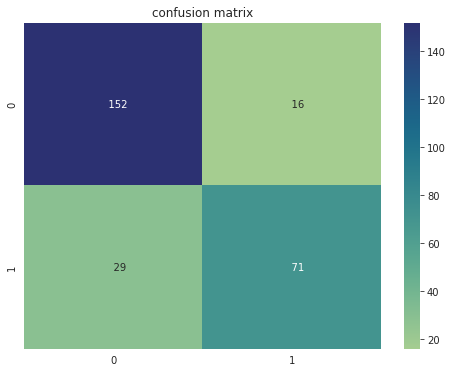

In [176]:
# confusion matrix 
conf_mx = confusion_matrix(y_test, y_pred)
sb.heatmap(conf_mx, annot=True, fmt='6.0f', cmap='crest')
plt.title('confusion matrix', size=12) 
conf_mx

Вернемся к тестовому датасету:

In [177]:
titanic_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic Dataset /titanic_clean_test.csv')  
titanic_test.head()

,Pclass,Sex,Age,Fare,family,Cabin_index
0,3,0,34.5,7.8292,0,0
1,3,1,47.0,7.0000,1,0
2,2,0,62.0,9.6875,0,0
3,3,0,27.0,8.6625,0,0
4,3,1,22.0,12.2875,2,0


In [178]:
# Random Forest & Cross-Validation
y_pred_test = rfc_opt.predict(titanic_test)
print("Выжило - ", sum(y_pred_test != 0))
print("Не выжило - ", sum(y_pred_test == 0))

Выжило -  139
Не выжило -  279


In [179]:
# Logistic Regression
y_pred_test = log_reg.predict(titanic_test) 
print("Выжило - ", sum(y_pred_test != 0))
print("Не выжило - ", sum(y_pred_test == 0))

Выжило -  151
Не выжило -  267


Прежде чем обучать модели, необходимо провести предварительную обработку данных, что мы и сделали в самом начале. В качестве данных мы решили рассмотреть известный датасет "Титаник". После небольшого анализа данных и работы над ними мы перешли непосредственно к обучению моделей машинного обучения. Здесь мы взяли в качестве примера - Logistic Regression, Linear Regression, Random Forest, KNN и Decision Tree. Лучшей оказалась модель - Логистическая регрессия, ее точность составляет ~ 0.828. После решили посмотреть, какой результат будет показывать модель Random Forest, если мы применим Cross Validation, а также займемся настройкой гиперпараметров. Получили следующий результат - точность модели значительно выросла и стала равной ~ 0.832. И в завершении решили вернуться к тестовому датасету и посмотреть, как будут классифицировать новых пассажиров модели Logistic Regression и Random Forest. 